In [1]:
%matplotlib inline

In [2]:
# Imported libraries
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import scipy.stats as st

In [3]:
# Imported python files
from functions import *
from input_variables import *

# IMPROVED OPEN-PIT BENCH BLASTING DESIGN, BASED ON OPTIMIZATION AND MONTE CARLO SIMULATION
# Vol. 3. Monte Carlo simulation and Hypothesis testing

## Overview

Now that we have obtained an optimal solution for the blast deisng parameter, we should evaluate how well it would perform in uncertain conditions, regarding the the rockmass properties. One parameter which is not always robustly estiamted is the Uniaxial compressive strenght ($UCS$) of the material, as sample gathering and experimental tests are expensive and time-consuming. Nonetheless, certain samples exhist in the geological database of the mining operation for each domain, and therefore it is possible to evaluate the UCS-data's distribution.

This case study implements the use of the conventional pen and paper solution and the two faster algorithms form *Vol. 2.*

## Distribution fitting for UCS data
### Data cleansing

Given that we have obtaiend certain measurements on how the $UCS$ differes for a single geological domain, we can use this data to analyze it and model it so that Monte Carlo simulation can be implemented into the optimization problem. Here you can see the sampled data for this example, whic utilizes a previous research by Karaman et al. (2015).

In [4]:
Rock_measurements = pd.read_csv("UCS_data.csv", header = None)
Rock_measurements.columns = ["Rock type", "UCS"]
Rock_measurements

,Rock type,UCS
0,Basalt,197.0
1,Metabasalt,158.0
2,Metabasalt,66.0
3,Metabasalt,146.0
4,Metabasalt,133.0
5,Basalt,95.0
6,Basalt,115.3
7,Basalt,152.4
8,Metabasalt,96.0
9,Metabasalt,111.0


Regardless that different samples are taken from different rock types, they can be part of the same geological domain and therefore can skew the overall UCS value for the rockmass and the Mean fragment size result, as well.
Here is a histogram of the observed UCS values.

In [5]:
ucs = Rock_measurements.UCS

In [6]:
def plot_histograms(args, colors, labels, f_bins, xlabel, ylabel, title, f_density = False):
    for i in range(len(args)):
        plt.hist(args[i], color = colors[i], label = labels[i], bins = f_bins[i], 
                 density = f_density, alpha = 0.5, edgecolor = "black")
    
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    
    plt.legend()
    plt.show()

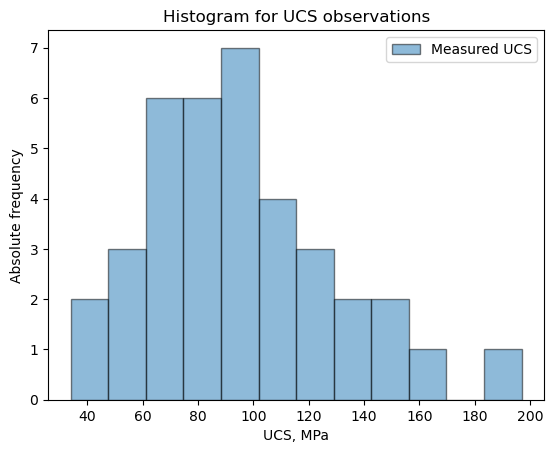

In [7]:
plot_histograms([ucs], ["tab:blue"], ["Measured UCS"], [12],
               "UCS, MPa", "Absolute frequency", "Histogram for UCS observations")

The histogram indicates that skewness is evident for the distribution of the UCS property in rockmass. In addition, there is a potential outlier for a sample with a UCS value of 197 MPa (Sample 1). Hence, the IQR rule could be useful for this case study by determining which samples fall out of 1.5 IQR from Q1 and Q3. 

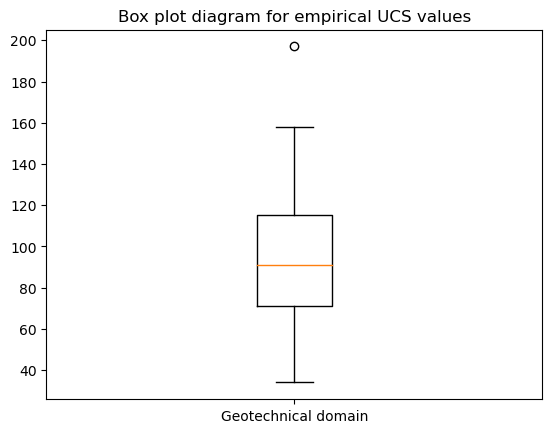

In [8]:
plt.boxplot([ucs], labels = ["Geotechnical domain"])
plt.title("Box plot diagram for empirical UCS values")

plt.show()

It can be asily seen that there is one outlier, based on the IQR rule. However, this observation is not disregarded as it can be interpreted as a valuable indicator of the possibility (no matter how small it can be) that there could be hard rock inclusions in the rockmass. Basalt is a very hard rock an most observations have lower values than typical UCS-values in similar mining sites. This is due to the present weathering and discontinuity of the rockmass, which can significantly influence the rock's strength properties. Of course, this assumption can be validated from future tests from the zone where the sample was taken from, which can validate or reject this assumption. Nonetheless, for this example it would be a good idea to include the possibility of reaching higher strength rock inclusions, as this is usually the problem as the powder factor of the design pattern becomes insufficient.

### Descriptive statistics
Now that we covered the problem with outliers, lets eastimate the sample's mean, standard deviation, kurtosis and skewness.

In [9]:
Rock_measurements.describe()

,UCS
count,37.000000
mean,95.275676
std,34.361755
min,34.000000
25%,71.000000
50%,91.000000
75%,115.300000
max,197.000000


The mean value for the UCS samples is estiamted to be 95.28 MPa, which is considered to be with a factor 9 to 10 from the Protodyakonov scale, hence it falls in the group of very hard rocks.

In [10]:
print(f"Median: {ucs.median():.2f} MPa\n\
Skewness: {ucs.skew():.4f}\n\
Kurtosis: {ucs.kurt():.4f}")

Median: 91.00 MPa
Skewness: 0.8005
Kurtosis: 0.9044


The positive skewness is illustrated by the assymetrical shape of the histogram. In addition, the high value of the Kurtosis indicats the the empirical distribution of data is leptokurtic. Therefore, a good initial assumpotion would be to attempt to fit a distribution different from the normal one. Past studies have successfully implemented a Weibull distribution to the empirical data. The assumed significance level for the test was assumed to be $\alpha = 0.01$. Hence, the following null and alternative hypotheses were assumed:

$H_{0}$: There is no evidence that the empirical and analytical distributions differ from each other.

$H_{a}$: There is evidence that the empirical and analytical distributions differ from each other.

The code block below implements the Kolmogorov-Smirnov statistical test. Its main purpose is to estimate the maximum difference in the probability values from the CDFs of the empirical data (also known as Empirical distribution function - EDF) and the best-fit CDF of the theoretical Weibull distribution, based on shape, scale and location parameters. The maximum difference is actually the Kolmogorov-Smirnov (K-S) statistic and it then the tests's p-value is evaluated, based on the K-S statistic. This notion is illustrated via the following figure:

<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/c/cf/KS_Example.png/450px-KS_Example.png"  width="40%">

The CDF of the Weibull distribution has the following formula:

$F(x) = 
\begin{cases}
    1 - e^{-(\frac{x}{\lambda})^{k}} & x \geq 0\\
    0  & x < 0
\end{cases}$


where $\lambda$ is the scale parameter of the distribution

$k$ is the distribution shape parameter

In [11]:
# Assumed siginificance level for hypothesis rejection
ks_sig_level = 0.01

# Best fit of shape and scale parameters to a Weibull distribution
weibull_params = st.weibull_min.fit(ucs, floc=0)
weibull_shape = weibull_params[0]
weibull_scale = weibull_params[2]

print(f"Best-fit values for a Weibull distribution to the sampled UCS-data:\n\
Shape: {weibull_shape:.2f}\n\
Scale: {weibull_scale:.2f}")

Best-fit values for a Weibull distribution to the sampled UCS-data:
Shape: 2.96
Scale: 106.72


In [12]:
#Estiamtion of KS statistic and p-value
ks_stat, ks_p_val = st.kstest(ucs, 'weibull_min', weibull_params)

if ks_p_val >= ks_sig_level:
    print(f"FAIL TO REJECT THE NULL HYPOTHESIS:\n\
The empirical distribution does not provide evidence that it differs from a Weibull distribution.")
else:
    print(f"REJECT THE NULL HYPOTHESIS:\n\
The empirical distribution provides evidence that it differs from a Weibull distribution.")
    
print(f"(p = {ks_p_val:.3f}, KS stat. = {ks_stat:.3f})")

FAIL TO REJECT THE NULL HYPOTHESIS:
The empirical distribution does not provide evidence that it differs from a Weibull distribution.
(p = 0.789, KS stat. = 0.103)


Results from the Kolmogorov-Smirnov Goodness-of-fit test show, that our initial assumption was reasonable and hence for the rest of the case study, we would use the theoretical Weibull distribution. This means that any deviations from it are assuemd to be the product from random noise in the UCS data.

Below, you can see the empirical distribution function (EDF) and the theoretical CDF of the best-fit Weibull distribution.

In [13]:
def weibull_dist(x, scale, shape, loc=0):
    return np.where(x >= 0, 1 - np.exp(-((x - loc) / scale) ** shape), 0)
    
vectorized_weibull_dist = np.vectorize(weibull_dist)

In [14]:
def plot_weibull_dist(scale, shape, max_x):
    x = np.linspace(0, max(ucs), 1000)
    y = vectorized_weibull_dist(x, weibull_scale, weibull_shape)
    
    plt.plot(x, y, label = "Weibull CDF")

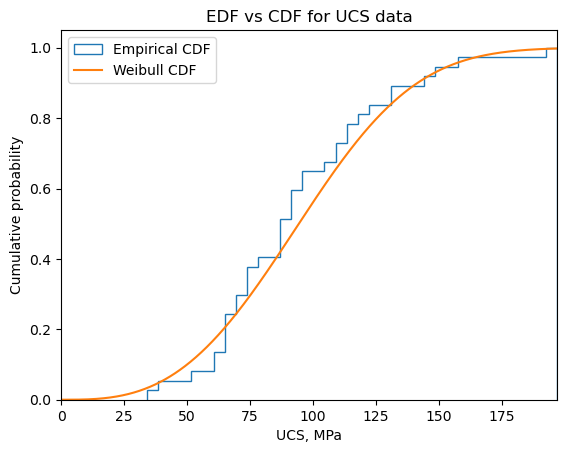

In [15]:
# Plot EDF and CDF
plt.hist(ucs, bins = 37, density = True, cumulative = True, histtype = 'step', label = 'Empirical CDF')
plot_weibull_dist(weibull_scale, weibull_shape, max(ucs))
plt.xlabel('UCS, MPa')
plt.ylabel('Cumulative probability')
plt.title('EDF vs CDF for UCS data')
plt.xlim(0, max(ucs))
plt.legend()

plt.show()

## Monte Carlo simulation for UCS

### Overview
Monte Carlo methods, also known as Monte Carlo experiments, encompass a broad range of computational algorithms that employ repeated random sampling to derive numerical outcomes. The fundamental idea behind these methods is to leverage randomness to address problems that may be inherently deterministic. They find widespread application in physical and mathematical domains, particularly when alternative approaches are challenging or infeasible. The primary application areas for Monte Carlo methods are optimization, numerical integration, and generating samples from probability distributions.

Additional instances where Monte Carlo methods prove valuable include modeling phenomena characterized by substantial uncertainty in input variables, such as assessing business risks, as well as evaluating complex multidimensional definite integrals with intricate boundary conditions in mathematics. In the realm of systems engineering, Monte Carlo-based predictions outperform human intuition when it comes to forecasting failures, cost overruns, and schedule delays.

### Implementation of Monte Carlo simulation
Now that we know the shape and scale of the best-fit Weibull distribution, we can do Monte Carlo simulations. First, we need to model the inverse of the Wibull CDF, which is modelled the following way:

$X = \lambda \cdot \bigl[-\ln(1-p)^{\frac{1}{k}}\bigr]$

In [16]:
def weibull_distribution_inverse(p, f_scale, f_shape):
    x = f_scale * (-np.log(1-p))**(1/f_shape)
    return x

Then, we need to vectorize it, so that we can feed an array of the probability values as an argument to the inverse function.

In [17]:
vectorized_weibull_distribution_inverse = np.vectorize(weibull_distribution_inverse)

Here you can see the draw of 1000 uniformly distributed random numbers in the interval [0, 1], which are used for calculating the inverse of the Weibull CDF, as tehy serve as an argument to the function.

In [18]:
# Monte Carlo simulation for UCS
p_rand_ucs = np.random.rand(1000)
sim_ucs_results = vectorized_weibull_distribution_inverse(p_rand_ucs, weibull_scale, weibull_shape)

Now let's plot it and see how it differs from the samples' distribution.

$H_{0}$: There is no evidence that the means of the empirical and analytical distributions differ from each other.

$H_{a}$: There is evidence that the means of the empirical and analytical distributions differ from each other.

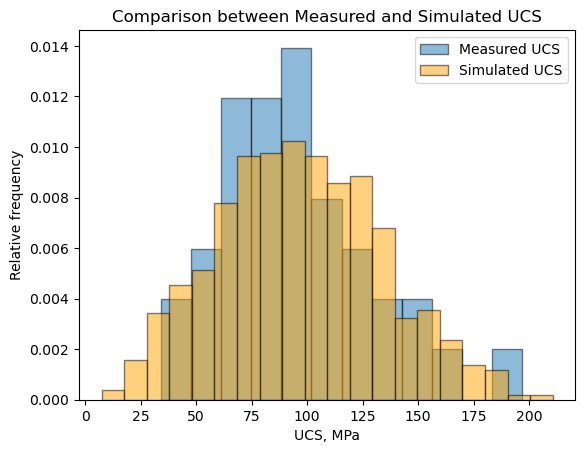

In [19]:
plot_histograms([ucs, sim_ucs_results], ["tab:blue", "orange"], ["Measured UCS", "Simulated UCS"], [12, 20],
               "UCS, MPa", "Relative frequency", "Comparison between Measured and Simulated UCS", True)

In [20]:
sig_level = 0.01

In [21]:
t_stat_ucs, t_p_val_ucs = st.ttest_ind(sim_ucs_results, ucs)

if t_p_val_ucs >= sig_level:
    print(f"In terms of mean value, there is no evidence that the Simulated data would yield different results.")
else:
    print(f"In terms of mean value, there is statistically signiciant evidence that the Simulated data would yield different results.")
    

print(f"t = {t_stat_ucs:.3f}\n\
p = {t_p_val_ucs:.3f},\n\
Mean difference: {(sim_ucs_results.mean() - ucs.mean()):.2f}") 

In terms of mean value, there is no evidence that the Simulated data would yield different results.
t = 0.251
p = 0.802,
Mean difference: 1.55


The simulated function for this case study simulation is for the Cunningham's Rock factor ($A$):

$ A = 0.06 \cdot (JF + RMD + RDI + HF)$

where $JF$ is the joint factor

$RMD$ is the rock mass designation

$RDI$ is the rock density influence

$HF$ is the hardness factor

Each of the following parameters is calculated via the following formulae:

$JF = JPO + JPS$

where $JPO$ is the joint plane orientation factor

$JPS$ is the joint plane spacing factor

Each of the two factors assume values via the following in-situ assessment of the rockmass joint sets:

$JPS = 
\begin{cases}
    10 & \text{Dip out of slope's face}  \\
    20  & \text{Dip perpendicular to slope's face} \\
    30  & \text{Dip into slope's face}  
\end{cases}$

$JPO = 
\begin{cases}
    20 & \text{Joint spacing up to 0.1 m}  \\
    30  & \text{Joint spacing from 0.1 m up to assumed oversize} \\
    40  & \text{Joint spacing bigger than assumed oversize}  
\end{cases}$

The $RMD$ can be estimated by assuming a value, depending on the condition of the rockmass:

$RMD = 
\begin{cases}
    10 & \text{Powdery/friable rock}  \\
    JF  & \text{Vertically jointed} \\
    50  & \text{Massive}  
\end{cases}$

The $RDI$ value is calculated via the following empirical formula:

$RDI = 25 \cdot \rho_{r} - 50$

Last, but not least, the $HF$ value is assumed depending on the elasticity properties of the rocks. The threshold value, which divides the rock types from soft to hard is assumed to be 50 GPa.

$HF = 
\begin{cases}
    E/3 & \text{if } E < 50 GPa \\
    UCS/5  & \text{if } E > 50 GPa
\end{cases}$

This case study assumes that the Young's module ($E$) is over 50 GPa and hence, the $UCS$ value is used for the calculation of the Hardness factor. Therefore, by simulating different values for the UCS, we can also simulate the distribution of the Rock factor and hence take into account the uncertainty behin its true value for the blast panel.

The `sim_rock_factor` function does exactly this by implementing the simulated distribtuion of the UCS value and incorporating it in the following formulae.

In [22]:
def sim_rock_factor(p, scale, shape, rm_density, rm_jpo, rm_jps, rm_rdi = 0):
    '''Transfer function for Rock factor Monte Carlo simulation'''
    
    rock_mass_designation = 25 * rm_density - 50
    joint_factor = rm_jpo + rm_jps
    rock_density_influence = joint_factor
    ucs_array= vectorized_weibull_distribution_inverse(p, scale, shape)
    hardness_factor_array = ucs_array / 5
    rock_factor_array = 0.06*(rock_mass_designation + joint_factor + rock_density_influence + hardness_factor_array)
    
    return rock_factor_array

Basically, the function is drawing balls from a hat with replacement and for each uniformly distributed value in the interval $[0, 1]$ it is applied to the inverse function of the Weibull distribution to obtain the respective $UCS$ value.

For this case study let's assume that the $JPO$ and $JPS$ values are 30 and 20 respetively, which means we are dealing with hard rock, which is highly discontinued and at the same tipe the orientation of planes makes the rockmass less durable.

In [23]:
rm_jpo = 30
rm_jps = 20

And finally, let's see how the simulated results of the Rock factor look like for this example.

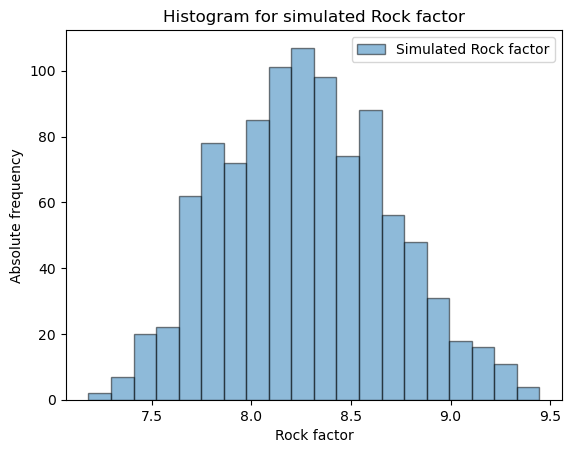

In [24]:
# Rock factor simulation
p_rand_rf = np.random.rand(1000) # Drawing [0, 1] random values from a uniform distribution 
rf_sim_results  = sim_rock_factor(p_rand_rf, weibull_scale, weibull_shape, rm_density, rm_jpo, rm_jps)

plot_histograms([rf_sim_results], ["tab:blue"], ["Simulated Rock factor"], [20],
               "Rock factor", "Absolute frequency", "Histogram for simulated Rock factor", False)

Now that we can imitate the UCS uncertainty in the rock mass, let's see how the different solutions from the previous botebook behave in different conditions.

## Comparsion between solutions

In order to compare how well different solutions work in these uncertain conditions, the design features from the conventional way of calculation have been used for comparison. In addition, two of the optimal solutions were also used for the comparison, including the solution from the Search with an accelerated step size (SASS) method and the Random search method (RS). Once omre, the assumed siginficance level is $\alpha = 0.01$.

In [25]:
significance_level = 0.01

Here the user can input the parameters for different design alternatvies, which one wants to compare by the t-test. The input provided for this example includes the Conventional solution, the RS solution and the SASS solution.

In [26]:
# Conventional solution - blast design
burden_conv = 5.57
spacing_conv = 5.57
subdrilling_conv = 1.67
stemming_conv = 5.57

# Conventional solution - charging rules
bp_dh_exp_mass_conv = calc_bp_dh_charge(burden_conv, spacing_conv, bp_height,
                                        subdrilling_conv, stemming_conv, bp_dh_diameter, expl_density)["DH charge mass, kg"]
bp_dh_spec_charge_conv = calc_bp_dh_charge(burden_conv, spacing_conv, bp_height,
                                        subdrilling_conv, stemming_conv, bp_dh_diameter, expl_density)["DH spec. charge, kg/m³"]
bp_dh_exp_length_conv = calc_bp_dh_charge(burden_conv, spacing_conv, bp_height,
                                        subdrilling_conv, stemming_conv, bp_dh_diameter, expl_density)["DH charge length, m"]

# Conventional solution - UCS simulation
p_rand_conv = np.random.rand(1000)
rock_factor_conv = sim_rock_factor(p_rand_conv, weibull_scale, weibull_shape, rm_density, rm_jpo, rm_jps)

In [27]:
# Random search solution - blast design
burden_RS = 4.52
spacing_RS = 5.89
subdrilling_RS = 1.53
stemming_RS = 6.86

# Random search solution - charging rules
bp_dh_exp_mass_RS = calc_bp_dh_charge(burden_RS, spacing_RS, bp_height,
                                       subdrilling_RS, stemming_RS, bp_dh_diameter, expl_density)["DH charge mass, kg"]
bp_dh_spec_charge_RS = calc_bp_dh_charge(burden_RS, spacing_RS, bp_height,
                                          subdrilling_RS, stemming_RS, bp_dh_diameter, expl_density)["DH spec. charge, kg/m³"]
bp_dh_exp_length_RS = calc_bp_dh_charge(burden_RS, spacing_RS, bp_height,
                                         subdrilling_RS, stemming_RS, bp_dh_diameter, expl_density)["DH charge length, m"]

# Random search solution - UCS simulation
p_rand_RS = np.random.rand(1000)
rock_factor_RS = sim_rock_factor(p_rand_RS, weibull_scale, weibull_shape, rm_density, rm_jpo, rm_jps)

In [28]:
# SASS solution - blast design
burden_SASS = 4.51
spacing_SASS = 5.89
subdrilling_SASS = 1.0
stemming_SASS = 6.46

# SASS solution - charging rules
bp_dh_exp_mass_SASS = calc_bp_dh_charge(burden_SASS, spacing_SASS, bp_height,
                                       subdrilling_SASS, stemming_SASS, bp_dh_diameter, expl_density)["DH charge mass, kg"]
bp_dh_spec_charge_SASS = calc_bp_dh_charge(burden_SASS, spacing_SASS, bp_height,
                                          subdrilling_SASS, stemming_SASS, bp_dh_diameter, expl_density)["DH spec. charge, kg/m³"]
bp_dh_exp_length_SASS = calc_bp_dh_charge(burden_SASS, spacing_SASS, bp_height,
                                         subdrilling_SASS, stemming_SASS, bp_dh_diameter, expl_density)["DH charge length, m"]

# SASS solution - UCS simulation
p_rand_SASS = np.random.rand(1000)
rock_factor_SASS = sim_rock_factor(p_rand_SASS, weibull_scale, weibull_shape, rm_density, rm_jpo, rm_jps)

The base hypothesis for each comparison is when comparing different design alternatives according to a certain criteria are as follows:

$H_{0}$: There is no evidence that the both solutions differ from each other in terms of the compared criteria.

$H_{a}$: There is evidence that the both solutions differ from each other in terms of the compared criteria.

### Mean fragment size ($X_{50}$) comparison

In [29]:
def plot_compared_histograms(args, colors, labels, means, mean_labels, f_bins, xlabel, ylabel, title, f_density = False):
    for i in range(len(args)):
        plt.hist(args[i], color = colors[i], label = labels[i], bins = f_bins[i], 
                 density = f_density, alpha = 0.5, edgecolor = "black")
        plt.axvline(means[i], color = colors[i], linestyle = 'dashed', linewidth = 2, label = mean_labels[i])
    
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    
    plt.legend()
    plt.show()

In [30]:
def t_test_ind_solution(samples, labels, criteria, f_sig_level = 0.05):
    t_stat, p_val = st.ttest_ind(samples[0], samples[1])
    
    if p_val >= f_sig_level:
        print(f"In terms of {criteria}, there is no evidence that the {labels[0]} solution would yield better results, compared to the {labels[1]} solution.")
    else:
        print(f"In terms of {criteria}, there is statistically significant evidence that the {labels[0]} solution would yield better results, compared to the {labels[1]} solution.")
    
    print(f"t = {t_stat:.3f},\np = {p_val:.3f},\nMean difference: {(np.mean(samples[0]) - np.mean(samples[1])):.2f}") 

In [31]:
def anova_solutions(samples, labels, criteria, f_sig_level = 0.05):
    f_stat, f_p_val = st.f_oneway(*[sample for sample in samples])

    if f_p_val >= f_sig_level:
        print("In terms of variance, there is no evidence that there is at least one sample with significantly different mean value.")
    else:
        print(f"In terms of variance, there is statistically significant evidence that\nthere is at least one sample with significantly different mean value.")


    print(f"F = {f_stat:.3f}\np = {f_p_val:.3f}") 

In [32]:
vectorized_calc_x50 = np.vectorize(calc_x50)

In [33]:
x50_array_conv = vectorized_calc_x50(bp_dh_exp_mass_conv, bp_dh_spec_charge_conv, rock_factor_conv, expl_rws)
x50_array_SASS = vectorized_calc_x50(bp_dh_exp_mass_SASS, bp_dh_spec_charge_SASS, rock_factor_SASS, expl_rws)
x50_array_RS = vectorized_calc_x50(bp_dh_exp_mass_RS, bp_dh_spec_charge_RS, rock_factor_RS, expl_rws)

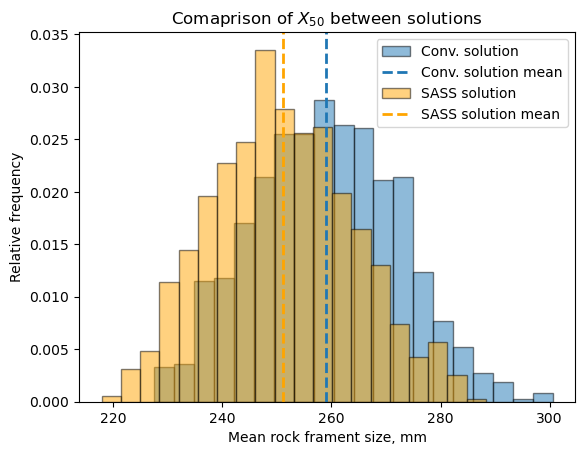

In [34]:
plot_compared_histograms([x50_array_conv, x50_array_SASS], ["tab:blue", "orange"], 
               ["Conv. solution", "SASS solution"], [np.mean(x50_array_conv), np.mean(x50_array_SASS)], 
               ["Conv. solution mean", "SASS solution mean"], [20, 20],
               "Mean rock frament size, mm", "Relative frequency", r"Comaprison of $X_{50}$ between solutions", True)

In [35]:
t_test_ind_solution([x50_array_conv, x50_array_SASS], ["Conventional", "SASS"], "Mean fragment size", significance_level)

In terms of Mean fragment size, there is statistically significant evidence that the Conventional solution would yield better results, compared to the SASS solution.
t = 13.464,
p = 0.000,
Mean difference: 7.92


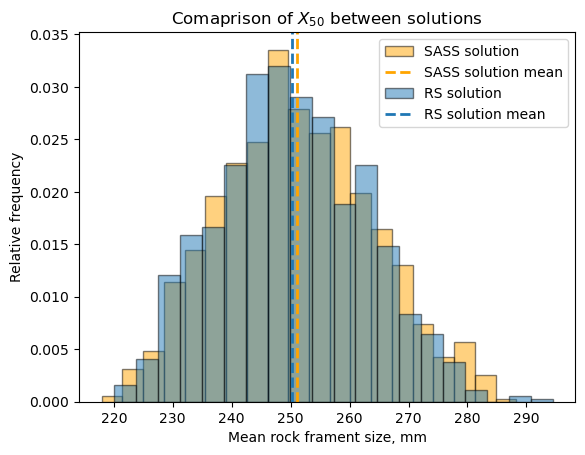

In [36]:
plot_compared_histograms([x50_array_SASS, x50_array_RS], ["orange", "tab:blue"], 
               ["SASS solution", "RS solution"], [np.mean(x50_array_SASS), np.mean(x50_array_RS)], 
               ["SASS solution mean", "RS solution mean"], [20, 20],
               "Mean rock frament size, mm", "Relative frequency", r"Comaprison of $X_{50}$ between solutions", True)

In [37]:
t_test_ind_solution([x50_array_SASS, x50_array_RS], ["SASS", "RS"], "Mean fragment size", significance_level)

In terms of Mean fragment size, there is no evidence that the SASS solution would yield better results, compared to the RS solution.
t = 1.499,
p = 0.134,
Mean difference: 0.85


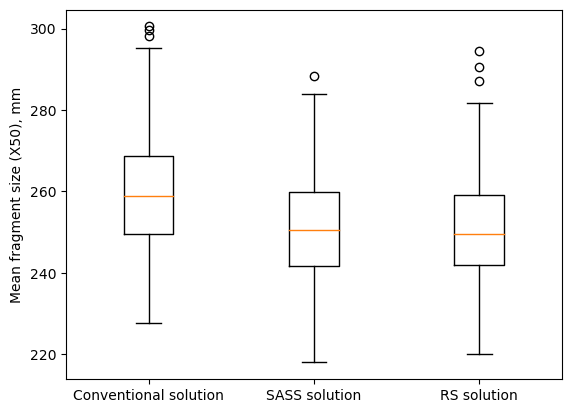

In terms of variance, there is statistically significant evidence that
there is at least one sample with significantly different mean value.
F = 139.967
p = 0.000


In [38]:
plt.boxplot([x50_array_conv, x50_array_SASS, x50_array_RS], 
            labels = ["Conventional solution", "SASS solution", "RS solution"])
plt.ylabel("Mean fragment size (X50), mm")

plt.show()

anova_solutions([x50_array_conv, x50_array_SASS, x50_array_RS], ["Conventional solution", "SASS solution", "RS solution"],
                "Mean fragment size", significance_level)

The SASS and RS solutions are very similar, however, they differ significantly from the Conventional one.

### Oversize percentage comparison

In [39]:
vectorized_uniformity_idx_mod = np.vectorize(calc_uniformity_idx_mod)
vectorized_kuz_ram_model = np.vectorize(kuz_ram_model)

In [40]:
n_conv = vectorized_uniformity_idx_mod(burden_conv, spacing_conv, bp_dh_diameter, 
                                       bp_dh_exp_length_conv, bp_dh_dev, bp_height, rock_factor_conv)

n_SASS = vectorized_uniformity_idx_mod(burden_SASS, spacing_SASS, bp_dh_diameter, 
                                       bp_dh_exp_length_SASS, bp_dh_dev, bp_height, rock_factor_SASS)

n_RS = vectorized_uniformity_idx_mod(burden_RS, spacing_RS, bp_dh_diameter, 
                                       bp_dh_exp_length_RS, bp_dh_dev, bp_height, rock_factor_RS)

In [41]:
oversize_array_conv = 100 - vectorized_kuz_ram_model(n_conv, x50_array_conv, 1000)
oversize_array_SASS = 100 - vectorized_kuz_ram_model(n_SASS, x50_array_SASS, 1000)
oversize_array_RS = 100 - vectorized_kuz_ram_model(n_RS, x50_array_RS, 1000)

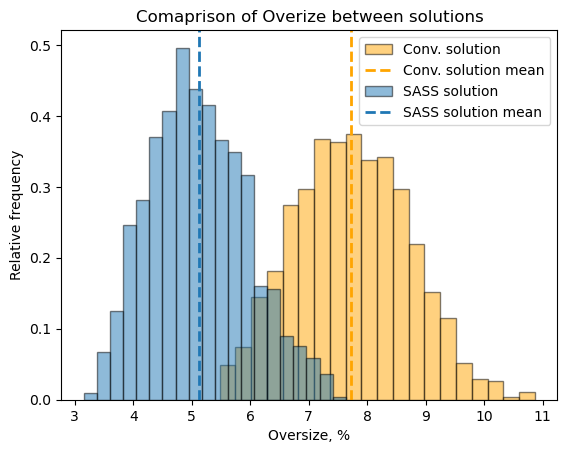

In [42]:
plot_compared_histograms([oversize_array_conv, oversize_array_SASS], ["orange", "tab:blue"], 
               ["Conv. solution", "SASS solution"], [np.mean(oversize_array_conv), np.mean(oversize_array_SASS)], 
               ["Conv. solution mean", "SASS solution mean"], [20, 20],
               "Oversize, %", "Relative frequency", "Comaprison of Overize between solutions", True)

In [43]:
t_test_ind_solution([oversize_array_conv, oversize_array_SASS], ["Conventional", "SASS"], "Oversize", significance_level)

In terms of Oversize, there is statistically significant evidence that the Conventional solution would yield better results, compared to the SASS solution.
t = 63.926,
p = 0.000,
Mean difference: 2.60


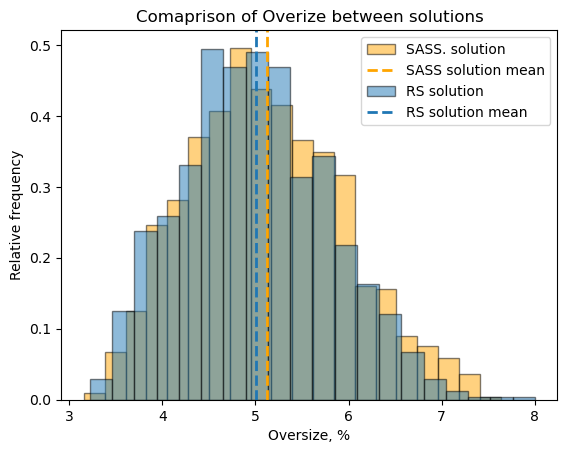

In [44]:
plot_compared_histograms([oversize_array_SASS, oversize_array_RS], ["orange", "tab:blue"], 
               ["SASS. solution", "RS solution"], [np.mean(oversize_array_SASS), np.mean(oversize_array_RS)], 
               ["SASS solution mean", "RS solution mean"], [20, 20],
               "Oversize, %", "Relative frequency", "Comaprison of Overize between solutions", True)

In [45]:
t_test_ind_solution([oversize_array_SASS, oversize_array_RS], ["SASS", "RS"], "Oversize", significance_level)

In terms of Oversize, there is statistically significant evidence that the SASS solution would yield better results, compared to the RS solution.
t = 3.305,
p = 0.001,
Mean difference: 0.12


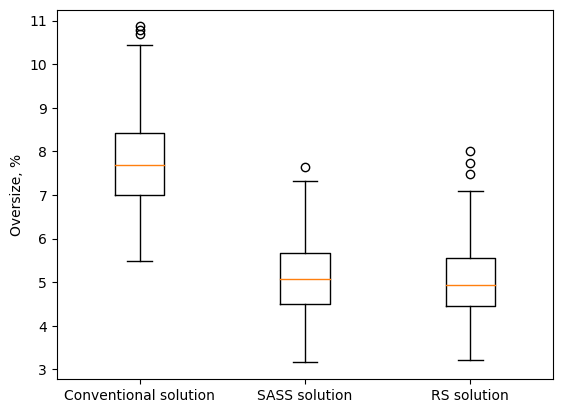

In terms of variance, there is statistically significant evidence that
there is at least one sample with significantly different mean value.
F = 3110.027
p = 0.000


In [46]:
plt.boxplot([oversize_array_conv, oversize_array_SASS, oversize_array_RS], 
            labels = ["Conventional solution", "SASS solution", "RS solution"])
plt.ylabel("Oversize, %")

plt.show()

anova_solutions([oversize_array_conv, oversize_array_SASS, oversize_array_RS], ["Conventional solution", "SASS solution", "RS solution"],
                "Oversize", significance_level)

Once more, the SASS and RS solutions are very similar, however, they differ significantly from the Conventional one.

In [63]:
def plot_kuz_ram_result(crusher_feed, x50, uniformity_idx, f_colour = "tab:blue", f_label = "Old uniformity model", lines = True):
    ''' Plots the CDF of the rock fragments for the Kuz-Ram model 
    Чертае кумулативната плътност на разпределението на скалните късове по модела Kuz-Ram '''

    x = np.arange(0, crusher_feed + 1000, 10)

    kuz_ram_model_vectorized = np.vectorize(kuz_ram_model)
    y = kuz_ram_model_vectorized(uniformity_idx, x50, x)
    
    if lines:
        plt.scatter(crusher_feed, kuz_ram_model(uniformity_idx, x50, crusher_feed), c = f_colour)
        x_const = np.linspace(0, crusher_feed + 1, 1000)
        y_const = np.linspace(0, kuz_ram_model(uniformity_idx, x50, crusher_feed), 1000)
        
        plt.axvline(crusher_feed, color = 'black', linestyle = 'dashed', linewidth = 2)
        plt.plot(x_const, [kuz_ram_model(uniformity_idx, x50, crusher_feed)] * 1000, color='black', linestyle="--")
    
    plt.plot(x, y, label = f_label, color = f_colour, linewidth = 0.01)
    plt.xlabel("Rock fragment size, mm")
    plt.ylabel("Passing, %")

    plt.xlim(0, crusher_feed + 1000)
    plt.ylim(0, 101)

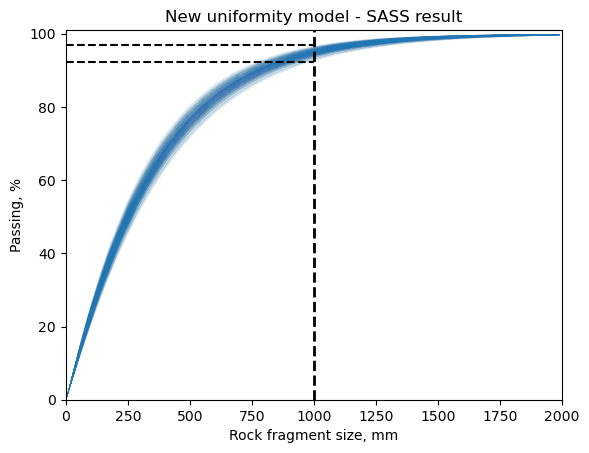

Oversize is expected to be in the range 3.16% - 7.63%


In [64]:
for x50 in x50_array_SASS:
    plot_kuz_ram_result(crusher_feed, x50, n_SASS[0], "tab:blue", "New uniformity model", False)

oversize_max = max(oversize_array_SASS)
#plt.scatter(crusher_feed, 100 - oversize_max, c = "tab:blue")
x_const_max = np.linspace(0, crusher_feed + 1, 1000)
plt.plot(x_const_max, [100 - oversize_max] * 1000, color='black', linestyle="--")

oversize_min = min(oversize_array_SASS)
#plt.scatter(crusher_feed, 100 - oversize_min, c = "tab:blue")
x_const_min = np.linspace(0, crusher_feed + 1, 1000)
plt.plot(x_const_min, [100 - oversize_min] * 1000, color='black', linestyle="--")
        
plt.axvline(crusher_feed, color = 'black', linestyle = 'dashed', linewidth = 2)

plt.title("New uniformity model - SASS result")
plt.show()

print(f"Oversize is expected to be in the range {oversize_min:.2f}% - {oversize_max:.2f}%")

In [49]:
oversize_series_conv = pd.Series(oversize_array_conv)
oversize_series_SASS = pd.Series(oversize_array_SASS)
oversize_series_RS = pd.Series(oversize_array_RS)

allowable_oversize = 5

print(f"Probability of oversize for Conventional solution: {100*len(oversize_series_conv[oversize_series_conv > allowable_oversize]) / len(oversize_series_conv)}%")
print(f"Probability of oversize for SASS solution: {100*len(oversize_series_SASS[oversize_series_SASS > allowable_oversize]) / len(oversize_series_SASS)}%")
print(f"Probability of oversize for RS solution: {100*len(oversize_series_RS[oversize_series_RS > allowable_oversize]) / len(oversize_series_RS)}%")

Probability of oversize for Conventional solution: 100.0%
Probability of oversize for SASS solution: 52.7%
Probability of oversize for RS solution: 47.0%


This could lead to a potential new optimization criteria, due to the possibility of exceedind the threshold of the allowable oversize percentage. In terms of visual representation, this is how the CDF of the rock fragment size would look like, when rock properties uncertainty is introduced into this analysis:

### Total costs comparison

In [50]:
def mining_ops(bp_burden, bp_spacing, bp_dh_subdrilling, bp_dh_stemming, rm_rock_factor):
    '''Caluclates total mining costs, based on blast deisng parameters and global variables for mining equipment, prices, 
    rockmass properties and blast panel features '''
    
    charge =  calc_bp_dh_charge(bp_burden, bp_spacing, bp_height, 
                                bp_dh_subdrilling, bp_dh_stemming, bp_dh_diameter, expl_density)
    bp_dh_length = charge["DH length, m"]
    bp_dh_exp_length = charge["DH charge length, m"]
    bp_dh_exp_mass = charge["DH charge mass, kg"]
    bp_dh_spec_charge = charge["DH spec. charge, kg/m³"]
    
    bp_total = calc_bp_total(bp_height, bp_width, bp_length, bp_slope_angle, 
                             bp_burden, bp_spacing, bp_dh_length, bp_dh_exp_mass)
    bp_dh_rows_cnt = bp_total["Rows"]
    bp_dh_per_row_cnt = bp_total["DHs per row"]
    bp_total_dh_cnt = bp_total["Total DH count"]
    bp_total_dh_length = bp_total["Total DH length, m"]
    bp_total_volume = bp_total["Total rock volume, m³"]
    bp_total_exp_mass = bp_total["Total explosive mass, kg"]
    
    frag_uniformity_idx_mod = calc_uniformity_idx_mod(bp_burden, bp_spacing, 
                                                      bp_dh_diameter, bp_dh_exp_length, bp_dh_dev, bp_height, rm_rock_factor)
    
    frag_x50 = calc_x50(bp_dh_exp_mass, bp_dh_spec_charge, rm_rock_factor, expl_rws)
    
    frag_oversize = 100 - 100 * kuz_ram_model(frag_uniformity_idx_mod, frag_x50, 1000)
    
    loader_fill_factor = set_fill_factor(frag_x50)
    loader_h_prod = 3600 / loader_s_cycle * loader_fill_factor * loader_bucket_vol / rm_swell_factor

    truck_tr_t = calc_truck_tr_t(loader_bucket_vol, rm_density, rm_swell_factor, loader_fill_factor, truck_cap_t)
    truck_h_prod =  truck_tr_t * (60 / truck_min_haul)
    
    costs_drilling = calc_drilling(bp_total_dh_length, drill_h_rate, drill_h_costs)["Costs"]
    costs_blasting = calc_blasting(bp_total_exp_mass, expl_price)["Costs"]
    costs_loading = calc_loading(bp_total_volume, loader_h_prod, loader_h_costs)["Costs"]
    costs_hauling = calc_hauling(bp_total_volume, truck_h_prod, truck_h_costs, rm_density)["Costs"]
    costs_total = costs_drilling + costs_blasting + costs_loading + costs_hauling
    
    result_dict = {"Burden, m": bp_burden,
                   "Spacing, m": bp_spacing,
                   "Stemming, m": bp_dh_stemming,
                   "Subdrilling, m": bp_dh_subdrilling,
                   "DH length, m": bp_dh_length,
                   "DH expl. mass, kg": bp_dh_exp_mass,
                   "DH spec. charge, kg/m³": bp_dh_spec_charge,
                   "Rows": bp_dh_rows_cnt,
                   "Holes per row": bp_dh_per_row_cnt,
                   "Total number of drillholes": bp_total_dh_cnt,
                   "Total drillhole length, m": bp_total_dh_length,
                   "Total explosive mass, kg": bp_total_exp_mass,
                   "Drilling costs, kEUR": costs_drilling,
                   "Blasting costs, kEUR": costs_blasting, 
                   "Loading costs, kEUR": costs_loading, 
                   "Haul costs, kEUR": costs_hauling, 
                   "Total costs, kEUR": costs_total, 
                   "X50, mm": frag_x50, 
                   "Uniformity index": frag_uniformity_idx_mod, 
                   "Oversize, %": frag_oversize}
    
    return result_dict

In [51]:
vectorized_mining_ops = np.vectorize(mining_ops)

In [52]:
Z_conv = vectorized_mining_ops(burden_conv, spacing_conv, subdrilling_conv, stemming_conv, rock_factor_conv)
Z_SASS = vectorized_mining_ops(burden_SASS, spacing_SASS, subdrilling_SASS, stemming_SASS, rock_factor_SASS)
Z_RS = vectorized_mining_ops(burden_RS, spacing_RS, subdrilling_RS, stemming_RS, rock_factor_RS)

total_costs_conv = [d["Total costs, kEUR"] for d in Z_conv]
total_costs_SASS = [d["Total costs, kEUR"] for d in Z_SASS]
total_costs_RS = [d["Total costs, kEUR"] for d in Z_RS]

total_costs_conv_mean = np.mean(total_costs_conv)
total_costs_SASS_mean = np.mean(total_costs_SASS)
total_costs_RS_mean = np.mean(total_costs_RS)

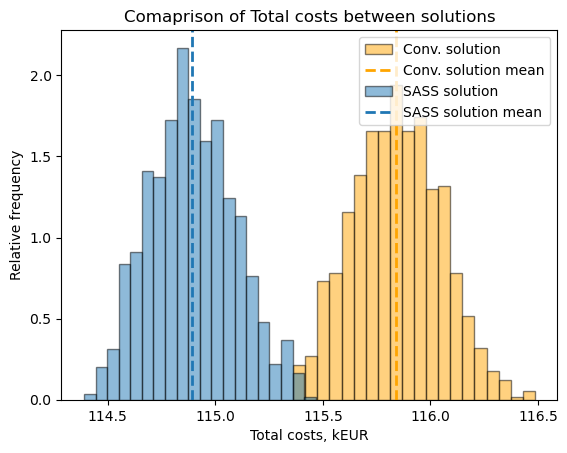

In [53]:
plot_compared_histograms([total_costs_conv, total_costs_SASS], ["orange", "tab:blue"], 
               ["Conv. solution", "SASS solution"], [total_costs_conv_mean, total_costs_SASS_mean], 
               ["Conv. solution mean", "SASS solution mean"], [20, 20],
               "Total costs, kEUR", "Relative frequency", "Comaprison of Total costs between solutions", True)

In [54]:
t_test_ind_solution([total_costs_conv, total_costs_SASS], ["Conventional", "SASS"], "Total costs", significance_level)

In terms of Total costs, there is statistically significant evidence that the Conventional solution would yield better results, compared to the SASS solution.
t = 105.106,
p = 0.000,
Mean difference: 0.95


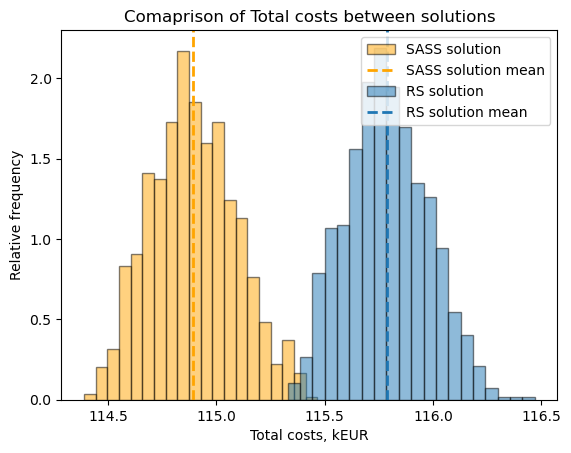

In [55]:
plot_compared_histograms([total_costs_SASS, total_costs_RS], ["orange", "tab:blue"], 
               ["SASS solution", "RS solution"], [total_costs_SASS_mean, total_costs_RS_mean], 
               ["SASS solution mean", "RS solution mean"], [20, 20],
               "Total costs, kEUR", "Relative frequency", "Comaprison of Total costs between solutions", True)

In [56]:
t_test_ind_solution([total_costs_SASS, total_costs_RS], ["SASS", "RS"], "Total costs", significance_level)

In terms of Total costs, there is statistically significant evidence that the SASS solution would yield better results, compared to the RS solution.
t = -102.560,
p = 0.000,
Mean difference: -0.89


The next figure shows a Box plot diagram which provides a good way of showing how different can the resutls be, regarding the three compared solutions.

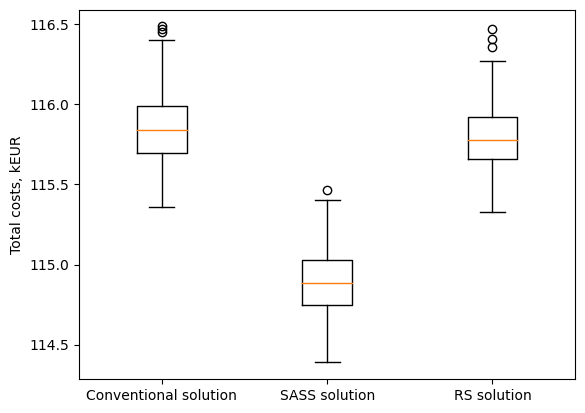

In terms of variance, there is statistically significant evidence that
there is at least one sample with significantly different mean value.
F = 7219.093
p = 0.000


In [57]:
plt.boxplot([total_costs_conv, total_costs_SASS, total_costs_RS], 
            labels = ["Conventional solution", "SASS solution", "RS solution"])
plt.ylabel("Total costs, kEUR")
plt.show()

anova_solutions([total_costs_conv, total_costs_SASS, total_costs_RS], ["Conventional solution", "SASS solution", "RS solution"],
                "Mean fragment size", significance_level)

All solutions differ from one another and still the SASS solution is the most optimal one, regardles of the fluctiations in the Total costs.

In [58]:
solution_savings = (np.mean(total_costs_conv) - np.mean(total_costs_SASS))*1000

print(f"The difference between the conventional and SASS solution in terms of Total costs is {solution_savings:.2f} EUR.")
print(f"Given that there are approximately 104 blast per year, this would bean that on average the savings for the mining operation would be {(104 * solution_savings):.2f} EUR per year.")

The difference between the conventional and SASS solution in terms of Total costs is 948.88 EUR.
Given that there are approximately 104 blast per year, this would bean that on average the savings for the mining operation would be 98683.01 EUR per year.


## Conclusion

This approach provides a step forward from the conventional otpimziation approach and hence for future research the objective function may need to be redefined in order to account for the probability of blasting scenarios exceeding the defiend Oversize threshold. Nonetheles, this compelx approach provides a good understanding how different solution from optimization algorithms can behave in different ways, given thatuncertainty is added into the model.
hence, solutions from reliable algorithms with a fast convergence rate are the next step in blast design optimization. This provides a fast way of estimating how suitable each blast design is in uncertain conditions in a very fast way, which is exactly what mining engineers are looking for - fast and efficient programs.
In addition, this also provides a way for mining engineers to test their solutions  with other similar ones, when Rock factor uncertainty is considered and evaluate how significantly they differ from each other.

Thank you for your attention! And sorry for the long read!

## Sources
Джобов, И., Копрев. И. Ръководство при процеси в открития добив на полезни изкопаеми. 2012. София.

Стоянов, С. Оптимизация на технологични процеси.1993, София.

Cunningham, C.V.B. (2005). The Kuz-Ram fragmentation model – 20 years on. Brighton Conference Proceedings 2005, R. Holmberg et al. 2005 European Federation of Explosives Engineers, ISBN 0-9550290-0-7

Gheibie, S., Aghababaei, H., Hoseinie, S. H., & Pourrahimian, Y. (2009). Modified Kuz—Ram fragmentation model and its use at the Sungun Copper Mine. International Journal of Rock Mechanics and Mining Sciences, 46(6), 967–973. doi:10.1016/j.ijrmms.2009.05.003

Karaman, K., Cihangir, F., Ercikdi, B., Kesimal, A., Demirel, S. (2015). Utilization of the Brazilian test for estimating the uniaxial compressive strength and shear strength parameters. The Journal of The Southern African Institute of Mining and Metallurgy. Vol. 115. March 2015. pp. 185-192.

Ozdemir, B., Kumral, M. (2019). A system-wide approach to minimize the operational cost of bench production in open-cast mining operations. Int J Coal Sci Technol 6, 84–94. https://doi.org/10.1007/s40789-018-0234-1